<a href="https://colab.research.google.com/github/mkorlyakova/MSTU-courses/blob/main/ML%20magister/16/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0_10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Самоорганизация**

## Эпизод 1
## Обучение без учителя

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split


from itertools import cycle
from math import hypot
from numpy import random


In [ ]:
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    #print(n_col)
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


In [ ]:
iris_=load_iris()

X_i=iris_.data


(1797, 64)


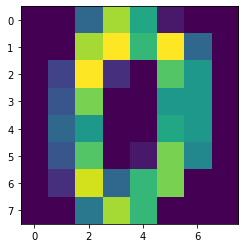

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

# примеры 

#входная часть
X_ = digits.data.reshape(digits.data.shape[0],8,8,1)
X_r = digits.data
# метка
Y_ = to_one_hot(digits.target)

# выводим пример
plt.imshow(X_[0,:,:,0])
plt.show()

print(Y_[0,:])

In [ ]:
# Метрика Минковского : a,b - вектора для сравнения (между ними вычислим расстояние)
# p - порядок метрики

def dist(a, b, ax=1,p=None):
    m=(np.sum((np.abs(a - b)**p),axis=1))
    return m**(1/p)

Пример пирменения метрик к точкам lin_mod2 = [0,0] и lin_mod2 =[x1, x2=x1]

p - устанавливаем в любое значение больше 0.

при больших р для маленьких абсолютных значений рх,ру - теряем значение (машинный 0) - но он должен быть:) - просто не видим в нашем виртуальном мире 

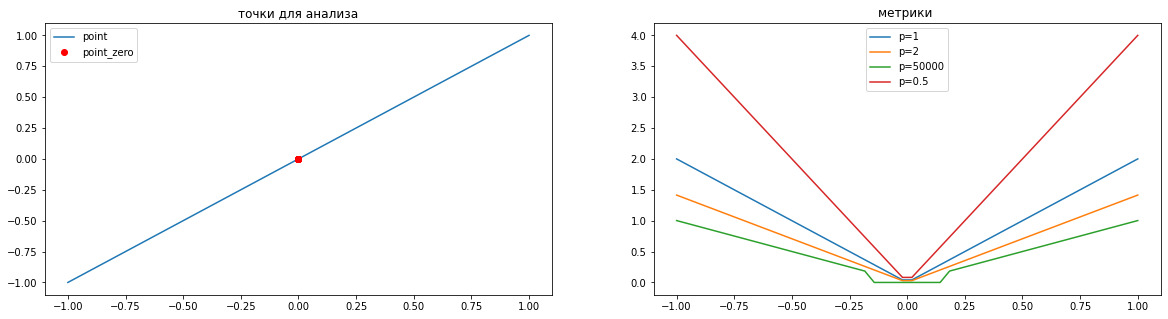

In [ ]:
M20=50

px=np.linspace(-1,1,(M20)).reshape((M20,1))

py=np.linspace(-1,1,(M20)).reshape((M20,1))
lin_mod1 = np.hstack([px,py])
lin_mod2 = np.hstack([np.zeros((M20,1)),np.zeros((M20,1))])

plt.figure(figsize=(20,5))
m1=dist(lin_mod1,lin_mod2,p=1)
m2=dist(lin_mod1,lin_mod2,p=2)
m100=dist(lin_mod1,lin_mod2,p=400)
m001=dist(lin_mod1,lin_mod2,p=0.5)

plt.subplot(1,2,1)
plt.plot(px,py, label='point')
plt.plot(lin_mod2[:,0],lin_mod2[:,1],'or', label='point_zero')
plt.legend()
plt.title('точки для анализа')

plt.subplot(1,2,2)
plt.plot(px,m1, label='p=1')
plt.plot(px,m2, label='p=2')
plt.plot(px,m100, label='p=50000')
plt.plot(px,m001, label='p=0.5')
plt.legend()
plt.title('метрики ')
plt.show()

## **Эпизод 3**

## Реализация обучения без учителя

K-means:

1. Нужно знать в сколько кластеров нужно распределить данные. Это является существенным минусом данного метода (зададим из каких-то логичных допущений).

2. Нужно выбрать начальные центры наших кластеров  (случайный пример из выборки). 

3. Нужно выбрать метрику (берем евклидово расстояние)

4. Для всех объектов производим оценку:  

- Считаем расстояние от объекта до каждого центра и определяем наименьшее расстояние (группа k).  
- Относим объект к группе k. 

5. Смещаем центр групппы как среднее по группе.

6. Все начинается сначала, до тех пор, пока не пройдет заданное число итераций или не перестаут смещаться центры


In [ ]:
# Основной цикл алгоритма k-means
def k_means(X=None,K=None, iteration = 10, p=2):
  # X -  входные данные - массив (строки объекты, столбцы признаки)
  # iteration - параметр для критерия останова (сколько раз повторять цикл алгоритма)
  # р - параметр метрики - по умолчанию Эвклид
  # к - число кластеров
  
  # строим случайный список индексов для заполнения начальных "старых" положений центров кластеров(групп)
  kk = np.random.randint(0,X.shape[0],(K))
  # строим старые кластеры
  C_old=X[kk,:].copy()
  # и еще раз, т.к. нужно инициировать переменную новое положение кластеров
  kk = np.random.randint(0,X.shape[0],(K))
  # новые кластеры
  C=X[kk,:].copy()
  clusters = np.zeros((X.shape[0]))
  error = np.mean(np.abs(C-C_old))

  # Цикл до наступления числа итераций или не изменения положения кластеров (error==0)
  iw=0
  #print(C)
  while ((error != 0) & (iw<iteration )):
    iw += 1
    #print(iw)
    # Разместим все объету по группам на основе определения ближайшего центра группы
    for i in range(X.shape[0]):
      distances = dist(C,X[i,:].reshape((1,X.shape[1])),ax=1,p=p)
      # выбираем ближайший центр
      cluster = np.argmin(distances)
      # присвоим номер кластера для i-го объекта
      clusters[i] = cluster
    # Сохраним старые положения центров кластеров
    #print(C)
    C_old = C.copy()
    # Вычислим новые положения центров кластеров
    for i in range(K):
      points=[]
      for j in range(X.shape[0]):
          if clusters[j] == i:
            points += [X[j,:]]
      # Для каждого из кластеров находим новый центр - среднее по всем объектам      
      C[i,:] = np.mean(points, axis=0)
    error = np.mean(np.abs(C-C_old))
  return C , clusters 

In [ ]:
# Разметка примеров метками для отображения (число меток labels не меньше числа кластеров)
def kmeans_export(clusters, data, labels):
    # clusters - номера кластеров по объектам
    # data - массив объектов
    res=[]
    # Формируем список меток для раскраски
    for i in range(clusters.shape[0]):
        res.append(labels[int(clusters[i])])
    return res


In [ ]:
def kmeans_draw(X, clusters,List_x=[0,1], text_t ='Кластеризация' ):
    #Рисуем результаты разметки (не больше 11 групп)
    # List_x -  список из 2-х координат для отображения
    colors = np.array([['or'], ['og'], ['ob'], ['oc'], ['om'], ['oy'], ['+k'],['+g'],['+k'],['+b'],['+r']])
    fig = plt.figure()
    # Выбираем цвет и маркер для каждой группы и отображаем объекты из Х с маркерами colors по clusters .

    for i in range(X.shape[0]):
        color = colors[clusters[i]][0]# назначаем маркер и цвет
        x, y = X[i,List_x] # назначаем значения координат точки
        plt.plot([x], [y],  color)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(text_t)

    plt.show()


Строим кластеры для Ирисов . Мы знаем, что их 3. Попробуем с к=3 - получаем не очень учстойчивую картину. Если К=2 - кластеризация устойчивая (одно и тоже). Однако порядок кластеров 1 или 0-й могут меняться от одной реализации к другой. Таким образом, смотрим не на цвет, а на форму, которую нашли.

Попробуйте перезапустить несколько раз и посмотрите как меняется картинка

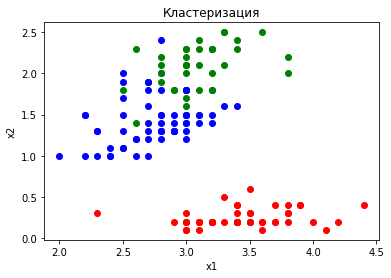

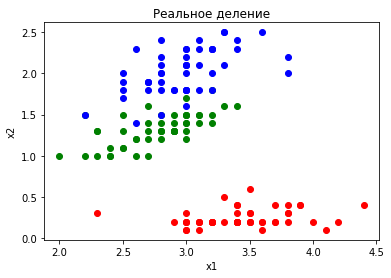

In [ ]:
# строим кластеры для Ирисов
centroids, clusters = k_means(X=X_i,K=3, iteration = 10)
K_res = kmeans_export(clusters, X_i, [0,1,2])
kmeans_draw(X_i, K_res,List_x=[1,3])

K_res = kmeans_export(iris_.target, X_i, [0,1,2])
kmeans_draw(X_i, K_res,List_x=[1,3], text_t ='Реальное деление' )

Посмотрим на более сложной картинке. И найдем кластеры тут. (попробуйте менять число кластеров  К. Истиное значение К=3)

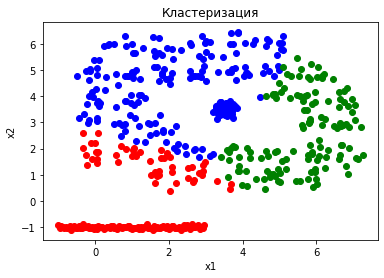

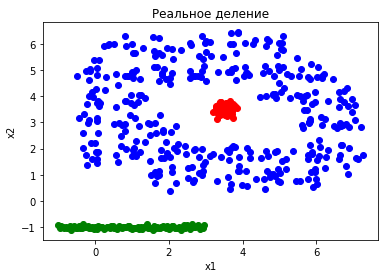

In [ ]:
# Генерация данных
# строим нормально размещенные точки вокруг центра [3.5,3.5]
P = [(random.randn()/8+3.5, random.randn()/8+3.5) for i in range(150)]
L_target=[0]*150
# Строим линию
P.extend([(i/25 - 1, + random.randn()/20 - 1) for i in range(100)])
L_target=L_target+[1]*100
# Строим бублик из первого объекта digits (это 0)
#  Считаем риксели с интенсивностью близкой к 1 точками для отображенияя 
#  в координатах [x,y] и вокруг каждой строим кр нормально распределенных точек с небольшой дисперсией
# Задаем фактор умножения для точек из картинки digits
kp=10
# Находим точки для отображения в выборку из картинки
P_data = np.where((digits.data[0].reshape((8,8)) >0.99))
#  добавляем примеров в обший список
P.extend([(P_data[0][i]+random.randn()/4-0.125,P_data[1][i]+random.randn()/4-0.125) for i in range(P_data[0].shape[0]) for j in range(kp)])
L_target=L_target+[2]*kp*P_data[0].shape[0]

L_target=np.array(L_target)
X_ = np.array(P)
#  делаем кластеризацию на К кластеров
centroids, clusters = k_means(X=X_,K=3, iteration = 10)
K_res = kmeans_export(clusters, X_, [0,1,2,3,4,5,6,7,8,9])
kmeans_draw(X_, K_res,List_x=[0,1])
K_res = kmeans_export(L_target, X_, [0,1,2,3,4,5,6,7,8,9])
kmeans_draw(X_, K_res,List_x=[0,1], text_t ='Реальное деление')


Получаем довольно слабый результат. Сложный кластер не построен. Попробуем построить более сложный алгоритм. Рассмотрим работу DBSCAN.

**DBSCAN**

Описание деталей работы алгоритма и масса примеров
https://www.pvsm.ru/python/245076

Реализован в библиотеке sklearn
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

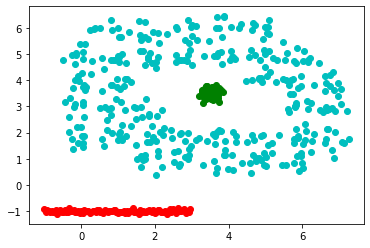

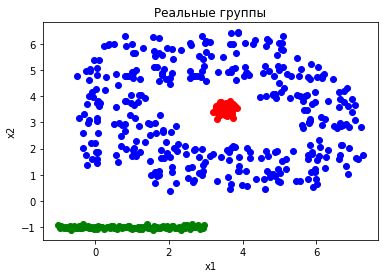

In [ ]:
def dbscan_naive(P=None, eps=0.2, m=3, distance=None):
    # инициализация
    NOISE = 0
    C = 0
    #  Посещенные точки
    visited_points = set()
    #  кластеризированные точки
    clustered_points = set()
    # шумовые точки (всякие выбросы)
    clusters = {NOISE: []}

    # условие попадания в обрасть вокруг точки по  всем из Р   
    def region_query(p):
        return [q for q in P if distance(p, q) < eps]
    #  расширение кластера - строим обход не распределенных точек 
    def expand_cluster(p, neighbours):
        # задаем новый кластер
        if C not in clusters:
            clusters[C] = []
        # Добавляем в него точку из р
        clusters[C].append(p)
        clustered_points.add(p)
        # ищем по соседям
        while neighbours:
            q = neighbours.pop()
            # если  не обошли точку
            if q not in visited_points:
                visited_points.add(q) # обходим
                neighbourz = region_query(q) # ищем ее соседей
                if len(neighbourz) > m:
                    neighbours.extend(neighbourz)
            # если не вкластере        
            if q not in clustered_points:
                # добавим в кластер
                clustered_points.add(q)
                clusters[C].append(q)
                # или если в шуме . то уберем из шума
                if q in clusters[NOISE]:
                    clusters[NOISE].remove(q)
    # По всем точкам из примеров Р
    for p in P:
        # если уже были, то дальше
        if p in visited_points:
            continue
        # иначе добавляем в список посещенных    
        visited_points.add(p)
        # ищем соседей
        neighbours = region_query(p)
        # если соседей мало, то в шумные точки 
        if len(neighbours) < m:
            clusters[NOISE].append(p)
        else:
            # иначе в кластер
            C += 1
            expand_cluster(p, neighbours)

    return clusters



# Запускаем кластеризацию для картинки с "бубликом"
clusters = dbscan_naive(P, 0.565, 5, lambda x, y: hypot(x[0] - y[0], x[1] - y[1]))

# рисуем результат
for c, points in zip(cycle('bgrcmykgrcmykgrcmykgrcmykgrcmykgrcmyk'), clusters.values()):
  X = [p[0] for p in points]
  
  Y = [p[1] for p in points]
  
  plt.scatter(X, Y, c=c)

plt.show()

# рисуем как должно было быть
X_ = np.array(P)

K_res = kmeans_export(L_target, X_, [0,1,2,3,4,5,6,7,8,9])
kmeans_draw(X_, K_res,List_x=[0,1],  text_t='Реальные группы')



Получили отличные кластеры

Посмотрим на модель сети Самоорганизации

## Эпизод 3

## **Self Organization Map**


Реализация по https://github.com/alexarnimueller/som

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from multiprocessing import cpu_count, Process, Queue


def man_dist_pbc(m, vector, shape=(10, 10)):
    # Манхетенская метрика
    # :param m: {numpy.ndarray} array / matrix
    # :param vector: {numpy.ndarray} array / vector
    # :param shape: {tuple} размер сети
    # :return: {numpy.ndarray} расстояние от vector до m
  
    dims = np.array(shape)
    delta = np.abs(m - vector)
    delta = np.where(delta > 0.5 * dims, np.abs(delta - dims), delta)
    return np.sum(delta, axis=len(m.shape) - 1)

# Сеть самоорганизации
class SOM(object):
    def __init__(self, x, y, alpha_start=0.6, seed=42):
        """ Инициализация сети по параметрам
        
        :param x: {int} ширина карты (число узлов по горизонтали)
        :param y: {int} Высота карты (число рядов узлов)
        :param alpha_start: {float} начальное значение alpha для обучения
        :param seed: {int} параметр для фиксации модели в генераторе случайных чисел
        """
        np.random.seed(seed) # можно выбросить будет веселее
        self.x = x
        self.y = y
        self.shape = (x, y)
        self.sigma = x / 2.
        self.alpha_start = alpha_start
        self.alphas = None
        self.sigmas = None
        self.epoch = 0
        self.interval = int()
        self.map = np.array([])
        self.indxmap = np.stack(np.unravel_index(np.arange(x * y, dtype=int).reshape(x, y), (x, y)), 2)
        self.distmap = np.zeros((self.x, self.y))
        self.winner_indices = np.array([])
        self.pca = None  # параметры рса для загрузки, если есть (РСА решит проблему мультиколлинеарности) 
        self.inizialized = False
        self.error = 0.  # ошибка 
        self.history = list()  # история обучения

    def initialize(self, data, how='pca'):
        """ инициализируем нейроны
        :param data: {numpy.ndarray} данные для работы
        :param how: {str} можно разными путями: 'pca' (для не менее чем 2-х координат) или'random' (для случайного выбора из данных)
        :return: начальное положение модели self.map
        """
        self.map = np.random.normal(np.mean(data), np.std(data), size=(self.x, self.y, len(data[0])))
        if how == 'pca':
            eivalues = PCA(2).fit_transform(data.T).T
            for i in range(2):
                self.map[np.random.randint(0, self.x), np.random.randint(0, self.y)] = eivalues[i]

        self.inizialized = True

    def winner(self, vector):
        """ Ищем победителя по (Euclidean distance)
        :param vector: {numpy.ndarray} вектор из текущих данных
        :return: номер нейрона победителя
        """
        # вычисляем Эвклидово расстояние от vector до всех нейронов - берем минимальное - победитель
        indx = np.argmin(np.sum((self.map - vector) ** 2, axis=2))
        return np.array([int(indx / self.x), indx % self.y])

    def cycle(self, vector):
        """ Цикл адаптации сети по текущему входному вектору(объекту)
        :param vector: {numpy.ndarray} текущий объект
        """
        w = self.winner(vector)
        # Находим близкие нейроны по Манхетенской метрике
        dists = man_dist_pbc(self.indxmap, w, self.shape)
        # Вычисляем параметр близости для нейронов сети
        h = np.exp(-(dists / self.sigmas[self.epoch]) ** 2).reshape(self.x, self.y, 1)
        # обновляем веса сети
        self.map -= h * self.alphas[self.epoch] * (self.map - vector)
        # отображение результатов обучения этого шага
        if self.epoch % 100 == 99:
          print("Epoch %i;    Neuron [%i, %i];    \tSigma: %.4f;    alpha: %.4f" %
                (self.epoch, w[0], w[1], self.sigmas[self.epoch], self.alphas[self.epoch]))
        self.epoch = self.epoch + 1

    def fit(self, data, epochs=0, save_e=False, interval=1000, decay='hill'):
        """ Обучение сети по шагам на данных
        :param data: {numpy.ndarray} данные для обучения
        :param epochs: {int} число итераций; Если 0, epochs=len(data) , то не меньше числа примеров
        :param save_e: {bool} Историю сохранять или нет
        :param interval: {int} Интервал сохранения истории
        :param decay: {str} Способ уменьшения alpha и sigma. Если  'hill' (Hill function) , если 'linear', с
            'hill',  то ``y = 1 / (1 + (x / 0.5) **4)``
        """
        self.interval = interval
        # Инициализация сети
        if not self.inizialized:
            self.initialize(data)
        if not epochs:
            epochs = len(data)
            indx = np.random.choice(np.arange(len(data)), epochs, replace=False)
        else:
            indx = np.random.choice(np.arange(len(data)), epochs)

        #Определим способ вычисления  alpha и sigma от числа эпох или по Хилл-функции
        if decay == 'hill':
            epoch_list = np.linspace(0, 1, epochs)
            self.alphas = self.alpha_start / (1 + (epoch_list / 0.5) ** 4)
            self.sigmas = self.sigma / (1 + (epoch_list / 0.5) ** 4)
        else:
            self.alphas = np.linspace(self.alpha_start, 0.05, epochs)
            self.sigmas = np.linspace(self.sigma, 1, epochs)

        if save_e:  # Если храним результаты, то записываем их через интервал
            for i in range(epochs):
                # исполняем один шаг работы-обновление сети (по одному объекту)
                self.cycle(data[indx[i]])
                if i % interval == 0:
                    self.history.append(self.som_error(data))
        else:
            for i in range(epochs):
                # исполняем шаг обновления сети по одному примеру 
                self.cycle(data[indx[i]])
        self.error = self.som_error(data)

    def transform(self, data):
        """ проход данных через SOM
        :param data: {numpy.ndarray}данные для обработки
        :return:результат прохода по сети
        """
        m = self.map.reshape((self.x * self.y, self.map.shape[-1]))
        dotprod = np.dot(np.exp(data), np.exp(m.T)) / np.sum(np.exp(m), axis=1)
        return (dotprod / (np.exp(np.max(dotprod)) + 1e-8)).reshape(data.shape[0], self.x, self.y)

    def distance_map(self, metric='euclidean'):
        """ Карта сети - расстояние между нейронами в сети(не в пространстве).
        :param metric: {str} используем метрику (scipy.spatial.distance.cdist)
        :return: нормализованные расстояния от нейрона до его соседей
        """
        dists = np.zeros((self.x, self.y))
        for x in range(self.x):
            for y in range(self.y):
                d = cdist(self.map[x, y].reshape((1, -1)), self.map.reshape((-1, self.map.shape[-1])), metric=metric)
                dists[x, y] = np.mean(d)
        self.distmap = dists / float(np.max(dists))

    def winner_map(self, data):
        """ Проверяем нейроны, как они часто побеждали по всем входным данным.
        :param data: {numpy.ndarray} data to compute the winner neurons on
        :return: {numpy.ndarray} возвращаем число побед нейронов по сетке
        """
        wm = np.zeros(self.shape, dtype=int)
        for d in data:
            [x, y] = self.winner(d)
            wm[x, y] += 1
        return wm

    def _one_winner_neuron(self, data, q):
        """Private function to be used for parallel winner neuron computation
        :param data: {numpy.ndarray} data matrix to compute the winner neurons on
        :param q: {multiprocessing.Queue} queue
        :return: {list} winner neuron cooridnates for every datapoint
        """
        q.put(np.array([self.winner(d) for d in data], dtype='int'))

    def winner_neurons(self, data):
        """ Находим нейрон победитель.
        :param data: {numpy.ndarray} данные для обработки (примеры)
        :return: {numpy.ndarray} winner neuron координаты победителя
        """
        print("Calculating neuron indices for all data points...")
        queue = Queue()
        n = cpu_count() - 1
        for d in np.array_split(np.array(data), n):
            p = Process(target=self._one_winner_neuron, args=(d, queue,))
            p.start()
        rslt = []
        for _ in range(n):
            rslt.extend(queue.get(10))
        self.winner_indices = np.array(rslt, dtype='int').reshape((len(data), 2))

    def _one_error(self, data, q):
        """Private function to be used for parallel error calculation
        :param data: {numpy.ndarray} data matrix to calculate SOM error for
        :param q: {multiprocessing.Queue} queue
        :return: {list} list of SOM errors
        """
        errs = list()
        for d in data:
            w = self.winner(d)
            dist = self.map[w[0], w[1]] - d
            errs.append(np.sqrt(np.dot(dist, dist.T)))
        q.put(errs)

    def som_error(self, data):
        """ Оцениваем ошибку
        :param data: {numpy.ndarray}
        :return: normalized error
        """
        queue = Queue()
        for d in np.array_split(np.array(data), cpu_count()):
            p = Process(target=self._one_error, args=(d, queue,))
            p.start()
        rslt = []
        for _ in range(cpu_count()):
            rslt.extend(queue.get(50))
        return float(sum(rslt) / float(len(data)))

    def get_neighbors(self, datapoint, data, labels, d=0):
        """ Найти всех соседей
        :param datapoint: {numpy.ndarray} данные для поиска (входной вектор)
        :param data: {numpy.ndarray} основные данные (матрица)
        :param labels: {numpy.ndarray} метки для ``data``
        :param d: {int} Близость по Манхетенской метрике для соседей точки (0: only same neuron as data point)
        :return: {numpy.ndarray} найденые нейроны (labels)
        """
        if not len(self.winner_indices):
            self.winner_neurons(data)
        labels = np.array(labels)
        w = self.winner(datapoint)
        print("Winner neuron of given data point: [%i, %i]" % (w[0], w[1]))
        dists = np.array([man_dist_pbc(winner, w, self.shape) for winner in self.winner_indices]).flatten()
        return labels[np.where(dists <= d)[0]]
    # ВИЗУАЛИЗАЦИИ
    def plot_point_map(self, data, targets, targetnames, filename=None, colors=None, markers=None, example_dict=None,
                       density=True, activities=None):
        """ Рисуем карту сети
        :param data: {numpy.ndarray} данные для обучения SOM
        :param targets: {list/array} метки по схеме данных
        :param targetnames: {list/array} Имена классов по разметке из данных (список уникальных меток)
        :param filename: {str} optional, if given, the plot is saved to this location
        :param colors: {list/array} optional, if given, different classes are colored in these colors
        :param markers: {list/array} optional, if given, different classes are visualized with these markers
        :param example_dict: {dict} Словарь с именами классов как values. 
        :param density: {bool} whether to plot the density map with winner neuron counts in the background
        :param activities: {list/array} list of activities (e.g. IC50 values) to use for coloring the points
            accordingly; high values will appear in blue, low values in green
        :return: plot shown or saved if a filename is given
        """
        if not markers:
            markers = ['o'] * len(targetnames)
        if not colors:
            colors = ['#EDB233', '#90C3EC', '#C02942', '#79BD9A', '#774F38', 'gray', 'black']
        if activities:
            heatmap = plt.get_cmap('coolwarm').reversed()
            colors = [heatmap(a / max(activities)) for a in activities]
        if density:
            fig, ax = self.plot_density_map(data, internal=True)
        else:
            fig, ax = plt.subplots(figsize=self.shape)

        for cnt, xx in enumerate(data):
            if activities:
                c = colors[cnt]
            else:
                c = colors[targets[cnt]]
            w = self.winner(xx)
            ax.plot(w[1] + .5 + 0.1 * np.random.randn(1), w[0] + .5 + 0.1 * np.random.randn(1),
                    markers[targets[cnt]], color=c, markersize=12)

        ax.set_aspect('equal')
        ax.set_xlim([0, self.x])
        ax.set_ylim([0, self.y])
        plt.xticks(np.arange(.5, self.x + .5), range(self.x))
        plt.yticks(np.arange(.5, self.y + .5), range(self.y))
        ax.grid(which='both')


        if example_dict:
            for k, v in example_dict.items():
                w = self.winner(v)
                x = w[1] + 0.5 + np.random.normal(0, 0.15)
                y = w[0] + 0.5 + np.random.normal(0, 0.15)
                plt.plot(x, y, marker='*', color='#FDBC1C', markersize=24)
                plt.annotate(k, xy=(x + 0.5, y - 0.18), textcoords='data', fontsize=18, fontweight='bold')

        plt.show()
    # Карта плотности 
    def plot_density_map(self, data, colormap='Oranges', filename=None, example_dict=None, internal=False):
        """ число примеров на узел SOM.
        :param data: {numpy.ndarray} data to visualize the SOM density (number of times a neuron was winner)
        :param colormap: {str} colormap to use, select from matplolib sequential colormaps
        :param filename: {str} optional, if given, the plot is saved to this location
        :param example_dict: {dict} dictionary containing names of examples as keys and corresponding descriptor values
            as values. These examples will be mapped onto the density map and marked
        :param internal: {bool} if True, the current plot will stay open to be used for other plot functions
        :return: plot shown or saved if a filename is given
        """
        wm = self.winner_map(data)
        fig, ax = plt.subplots(figsize=self.shape)
        plt.pcolormesh(wm, cmap=colormap, edgecolors=None)
        plt.colorbar()
        plt.xticks(np.arange(.5, self.x + .5), range(self.x))
        plt.yticks(np.arange(.5, self.y + .5), range(self.y))
        ax.set_aspect('equal')

        if example_dict:
            for k, v in example_dict.items():
                w = self.winner(v)
                x = w[1] + 0.5 + np.random.normal(0, 0.15)
                y = w[0] + 0.5 + np.random.normal(0, 0.15)
                plt.plot(x, y, marker='*', color='#FDBC1C', markersize=24)
                plt.annotate(k, xy=(x + 0.5, y - 0.18), textcoords='data', fontsize=18, fontweight='bold')

        if not internal:
            plt.show()
        else:
            return fig, ax
    # Узды по классам
    def plot_class_density(self, data, targets, t=1, name='actives', colormap='Oranges', example_dict=None,
                           filename=None):
        """ Plot a density map only for the given class
        :param data: {numpy.ndarray} data to visualize the SOM density (number of times a neuron was winner)
        :param targets: {list/array} array of target classes (0 to len(targetnames)) corresponding to data
        :param t: {int} target class to plot the density map for
        :param name: {str} target name corresponding to target given in t
        :param colormap: {str} colormap to use, select from matplolib sequential colormaps
        :param example_dict: {dict} dictionary containing names of examples as keys and corresponding descriptor values
            as values. These examples will be mapped onto the density map and marked
        :param filename: {str} optional, if given, the plot is saved to this location
        :return: plot shown or saved if a filename is given
        """
        targets = np.array(targets)
        t_data = data[np.where(targets == t)[0]]
        wm = self.winner_map(t_data)
        fig, ax = plt.subplots(figsize=self.shape)
        plt.pcolormesh(wm, cmap=colormap, edgecolors=None)
        plt.colorbar()
        plt.xticks(np.arange(.5, self.x + .5), range(self.x))
        plt.yticks(np.arange(.5, self.y + .5), range(self.y))
        plt.title(name, fontweight='bold', fontsize=28)
        ax.set_aspect('equal')
        plt.text(0.1, -1., "%i Datapoints" % len(t_data), fontsize=20, fontweight='bold')

        if example_dict:
            for k, v in example_dict.items():
                w = self.winner(v)
                x = w[1] + 0.5 + np.random.normal(0, 0.15)
                y = w[0] + 0.5 + np.random.normal(0, 0.15)
                plt.plot(x, y, marker='*', color='#FDBC1C', markersize=24)
                plt.annotate(k, xy=(x + 0.5, y - 0.18), textcoords='data', fontsize=18, fontweight='bold')

        plt.show()
    # Карта расстояний после тренировки
    def plot_distance_map(self, colormap='Oranges', filename=None):
        """ Plot the distance map after training.
        :param colormap: {str} colormap to use, select from matplolib sequential colormaps
        :param filename: {str} optional, if given, the plot is saved to this location
        :return: plot shown or saved if a filename is given
        """
        if np.mean(self.distmap) == 0.:
            self.distance_map()
        fig, ax = plt.subplots(figsize=self.shape)
        plt.pcolormesh(self.distmap, cmap=colormap, edgecolors=None)
        plt.colorbar()
        plt.xticks(np.arange(.5, self.x + .5), range(self.x))
        plt.yticks(np.arange(.5, self.y + .5), range(self.y))
        plt.title("Distance Map", fontweight='bold', fontsize=28)
        ax.set_aspect('equal')
        plt.show()
    # рисуем историю 
    def plot_error_history(self, color='orange', filename=None):
        """ plot the training reconstruction error history that was recorded during the fit
        :param color: {str} color of the line
        :param filename: {str} optional, if given, the plot is saved to this location
        :return: plot shown or saved if a filename is given
        """
        if not len(self.history):
            raise LookupError("No error history was found! Is the SOM already trained?")
        fig, ax = plt.subplots()
        ax.plot(range(0, self.epoch, self.interval), self.history, '-o', c=color)
        ax.set_title('SOM Error History', fontweight='bold')
        ax.set_xlabel('Epoch', fontweight='bold')
        ax.set_ylabel('Error', fontweight='bold')
        plt.show()


Обучим сеть SOM на данных с "картинкой бублика"

Epoch 99;    Neuron [4, 1];    	Sigma: 2.5000;    alpha: 0.6000
Epoch 199;    Neuron [4, 2];    	Sigma: 2.5000;    alpha: 0.6000
Epoch 299;    Neuron [3, 2];    	Sigma: 2.5000;    alpha: 0.6000
Epoch 399;    Neuron [0, 1];    	Sigma: 2.4999;    alpha: 0.6000
Epoch 499;    Neuron [0, 3];    	Sigma: 2.4998;    alpha: 0.5999
Epoch 599;    Neuron [0, 2];    	Sigma: 2.4995;    alpha: 0.5999
Epoch 699;    Neuron [0, 0];    	Sigma: 2.4990;    alpha: 0.5998
Epoch 799;    Neuron [4, 4];    	Sigma: 2.4984;    alpha: 0.5996
Epoch 899;    Neuron [1, 0];    	Sigma: 2.4974;    alpha: 0.5994
Epoch 999;    Neuron [2, 3];    	Sigma: 2.4960;    alpha: 0.5990
Epoch 1099;    Neuron [4, 1];    	Sigma: 2.4942;    alpha: 0.5986
Epoch 1199;    Neuron [4, 1];    	Sigma: 2.4918;    alpha: 0.5980
Epoch 1299;    Neuron [4, 0];    	Sigma: 2.4887;    alpha: 0.5973
Epoch 1399;    Neuron [2, 4];    	Sigma: 2.4848;    alpha: 0.5963
Epoch 1499;    Neuron [1, 3];    	Sigma: 2.4800;    alpha: 0.5952
Epoch 1599;    Neuron

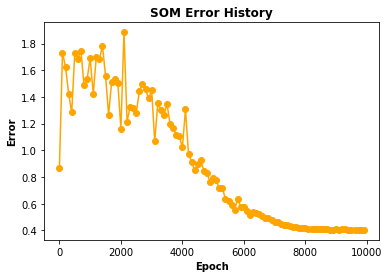

In [ ]:
# данные для обучения (тут Nх2)

data =X_

som = SOM(5, 5)  # создаем SOM
som.fit(data, 10000, save_e=True, interval=100)  # fit  SOM для 10000 epochs, и сохраняем через 100 шагов
som.plot_error_history(filename='som_error.png')  # Отобразим историю

targets = L_target  # вспоминаем, что у нас были метки - добавим их для визуализации



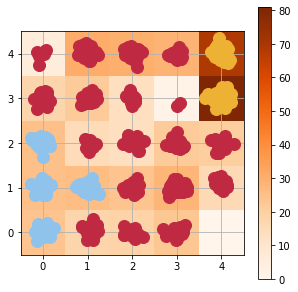

In [ ]:
# Карта по точкам
som.plot_point_map(data, targets, ['Class 0', 'Class 1', 'Class 2'], filename='som.png')

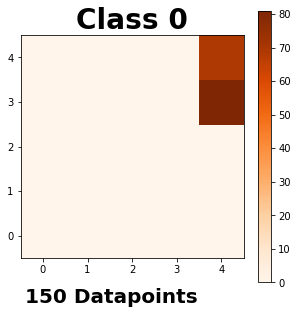

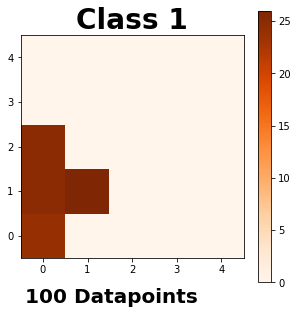

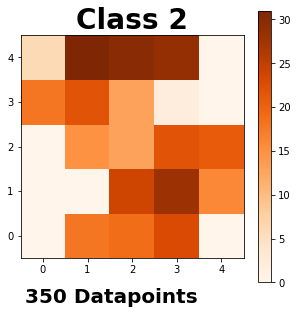

In [ ]:
# Карты по классам

som.plot_class_density(data, targets, t=0, name='Class 0', filename='class_0.png')
som.plot_class_density(data, targets, t=1, name='Class 1', filename='class_1.png')
som.plot_class_density(data, targets, t=2, name='Class 2', filename='class_2.png')


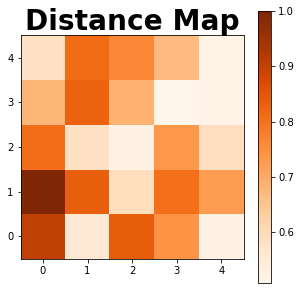

In [ ]:
som.plot_distance_map(filename='distance_map.png')  # карта плотности после тренировки

### **Эмбединг**

In [ ]:
P_data

(array([0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4,
        5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7]),
 array([2, 3, 4, 5, 2, 3, 4, 5, 6, 1, 2, 3, 5, 6, 1, 2, 5, 6, 1, 2, 5, 6,
        1, 2, 4, 5, 6, 1, 2, 3, 4, 5, 2, 3, 4]))

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(5, 2, input_length=5))

input_array = np.random.randint(5, size=(1, 5))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)



1/1 [==============================] - 0s 328ms/step


In [ ]:
input_array

array([[4, 3, 3, 4, 3]])

In [ ]:
output_array

array([[[-0.04784833, -0.03866585],
        [ 0.01358768, -0.02306064],
        [ 0.01358768, -0.02306064],
        [-0.04784833, -0.03866585],
        [ 0.01358768, -0.02306064]]], dtype=float32)

## Эпизод 4
## **Restricted Boltzmann Machine (RBM)** 
с алгоритмом Contrastive Divergence

Реализация по 
https://gist.github.com/yusugomori/4428308

In [ ]:
import sys

np.seterr(all='ignore')

# Сигмоид
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

# Класс для реализации RBM
class RBM(object):
    def __init__(self, input=None, n_visible=2, n_hidden=3, \
        W=None, hbias=None, vbias=None, numpy_rng=None):
        #  Инициализация 
        self.n_visible = n_visible  # число нейронов видимых - visible (input) layer
        self.n_hidden = n_hidden    # число нейронов скрытых -  hidden layer

        if numpy_rng is None:
            numpy_rng = np.random.RandomState(1234)


        if W is None:
            a = 1. / n_visible
            initial_W = np.array(numpy_rng.uniform(  # инициализируем веса маленьким случайным числом
                low=-a,
                high=a,
                size=(n_visible, n_hidden)))

            W = initial_W

        if hbias is None:
            hbias = np.zeros(n_hidden)  # инициализация сдвига для  h в 0

        if vbias is None:
            vbias = np.zeros(n_visible)  # инициализация сдвига для v в 0


        self.numpy_rng = numpy_rng
        self.input = input
        self.W = W
        self.hbias = hbias
        self.vbias = vbias

        # self.params = [self.W, self.hbias, self.vbias]

    # АЛГОРИТМ ОБУЧЕНИЯ
    def contrastive_divergence(self, lr=0.1, k=1, input=None):
        # к - число итераций для одного шага адаптации (сколько циклов сделаем для поиска градиента)
        # lr -  скорость обучения
        # input - входные вектора
        if input is not None:
            self.input = input
        
        ''' CD-k '''
        # вероятность для h,v - начальная
        ph_mean, ph_sample = self.sample_h_given_v(self.input)

        # фиксируем вход
        chain_start = ph_sample
        # делаем к итераций для определения вероятности (к кругов по обратной связи)
        for step in range(k):
            if step == 0:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(chain_start)
            else:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(nh_samples)

        # chain_end = nv_samples

        #  Получили значение вероятности P(h,Xj) и будем изменять свои веса 
        self.W += lr * (np.dot(self.input.T, ph_sample)
                        - np.dot(nv_samples.T, nh_means))
        self.vbias += lr * np.mean(self.input - nv_samples, axis=0)
        self.hbias += lr * np.mean(ph_sample - nh_means, axis=0)

        # cost = self.get_reconstruction_cross_entropy()
        # return cost

    # Определяем вероятность для модели (среднюю по модели и по данным) для скрытого нейрона
    def sample_h_given_v(self, v0_sample):
        h1_mean = self.propup(v0_sample)
        h1_sample = self.numpy_rng.binomial(size=h1_mean.shape,   # discrete: binomial
                                       n=1,
                                       p=h1_mean)

        return [h1_mean, h1_sample]

    # Определяем вероятность для модели (среднюю по модели и по данным) для видимого нейрона
    def sample_v_given_h(self, h0_sample):
        v1_mean = self.propdown(h0_sample)
        v1_sample = self.numpy_rng.binomial(size=v1_mean.shape,   # discrete: binomial
                                            n=1,
                                            p=v1_mean)
        
        return [v1_mean, v1_sample]
    # Работает нейрон вперед
    def propup(self, v):
        pre_sigmoid_activation = np.dot(v, self.W) + self.hbias
        return sigmoid(pre_sigmoid_activation)
    # Работает нейроно обратно
    def propdown(self, h):
        pre_sigmoid_activation = np.dot(h, self.W.T) + self.vbias
        return sigmoid(pre_sigmoid_activation)

    # Функция Гибса
    def gibbs_hvh(self, h0_sample):
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample)

        return [v1_mean, v1_sample,
                h1_mean, h1_sample]
    
    # Определяем оценку (кросс-энтропия)
    def get_reconstruction_cross_entropy(self):
        pre_sigmoid_activation_h = np.dot(self.input, self.W) + self.hbias
        sigmoid_activation_h = sigmoid(pre_sigmoid_activation_h)
        
        pre_sigmoid_activation_v = np.dot(sigmoid_activation_h, self.W.T) + self.vbias
        sigmoid_activation_v = sigmoid(pre_sigmoid_activation_v)

        cross_entropy =  - np.mean(
            np.sum(self.input * np.log(sigmoid_activation_v) +
            (1 - self.input) * np.log(1 - sigmoid_activation_v),
                      axis=1))
        
        return cross_entropy
    # Определяем выход сети для данных
    def reconstruct(self, v):
        h = sigmoid(np.dot(v, self.W) + self.hbias)
        reconstructed_v = sigmoid(np.dot(h, self.W.T) + self.vbias)
        return reconstructed_v

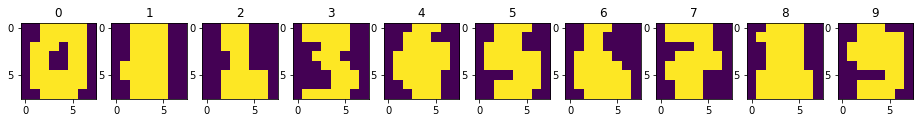

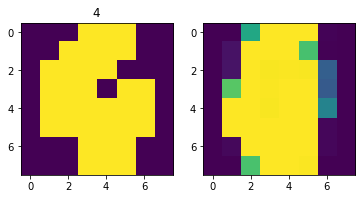

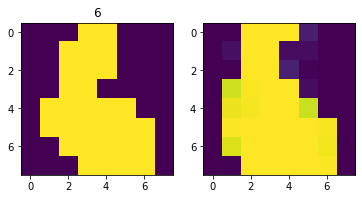

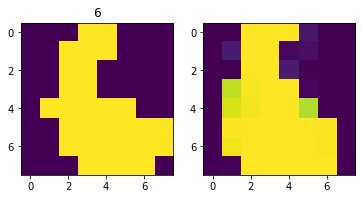

In [ ]:
# Определяем параметры примера
N=64 # номер первого примера для тестов
learning_rate=0.1 # скорость обучения
k=10 # число циклов по CD-k
training_epochs=1000 # число эпох
ind=[]

# Определяем примеры для запоминания в модели (10 примеров цифр - по одной на класс)
for n in range(10):
  ind_i=np.where(digits.target==n)[0]
  ind.append(ind_i[ind_i.shape[0]-1])
# нормализуем и векторизируем данные - значения на входах только 0/1
X_1 = (digits.data.reshape(digits.data.shape[0],64)>0.9999).astype('int')
# Определяем примеры для обучения
data = np.array(X_1[ind,:])
rng = np.random.RandomState(100)

# строим RBM
rbm = RBM(input=data, n_visible=64, n_hidden=32, numpy_rng=rng)

# тренируем
loss=[]

for epoch in range(training_epochs):
  rbm.contrastive_divergence(lr=learning_rate, k=k)
  cost = rbm.get_reconstruction_cross_entropy()
  #print(sys.stderr, 'Training epoch %d, cost is ' % epoch, cost)
  loss.append(cost)
# Отображаем
plt.figure(figsize=(16,5))
for i in range(10):
  
  plt.subplot(1,10,i+1)
  plt.title(str(i))
  plt.imshow(data[i,:].reshape((8,8))/np.max(data[i,:]))

plt.show()

# test
L=3
v = X_1[N:N+L,:]
rez=rbm.reconstruct(v)
#print()
for i in range(L):
  plt.subplot(1,2,1)
  plt.title(str(digits.target[N+i]))
  plt.imshow(X_1[N+i,:].reshape((8,8))/np.max(X_1[N+i,:]))
  plt.subplot(1,2,2)
  plt.imshow(rez[i,:].reshape((8,8)))
  plt.show()


Результаты работы модели:

- Модель запомнила 10 примеров - (они очень простые из 0 и 1 по 64 признака на каждый пример)

- Модель получает на вход примеры (тип примера обозначен в названии рисунков, а возвращает образец из своего архива (весь архив примеров в первой строке рисунков))

- По смазаным данным восстанавлимваем чистый образ


Изменение ошибки обучения приведено ниже:

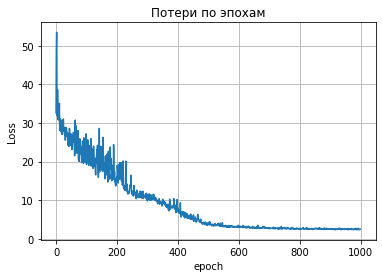

In [ ]:
plt.plot(loss)
plt.title('Потери по эпохам')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

## **Домашнее задание**

Ligth

 1. Используйте данные "Ирисы" и постройте для них SOM и DBSCAN
 2. Cравните результаты с k-Means , DBSCAN, SOM - ориентируемся на метки классов и разметку кластеров - число совпадений (помним, что номер кластера не обязан соответствовать номеру класса, т.е. при каждом запуске следует установить пары - автоматически(написать код) или визуально и вручную указать пары соответствий)
 3. Сделайте вывод - какой из алгоритмов строит более точное разледение на группы для Ирисов.
 4. Запустите  k-Means , DBSCAN, SOM  для Digits - оцените качество группировки
 5. Сранвните с результатами работы для Ирисов

Pro

1. Исследуйте изменение качества восстановления образцов для RBM при изменении следующих параметров:
 - числа скрытых нейронов
 - параметра к (1, 2, .., 10)
 - числа примеров на вход для обучения (берем по 2-10 примеров каждого класса) и числа классов (берем 2 класса, 5 - классов, 10 - классов)
2. Оцените как изменилось качество восстановления объекта на входе (например как косинусное расстояние) с эталоном как среднее по выборке.
3. Проведите обучение SOM для представления digits и определите качество соотнесения объекта на входе (например как косинусное расстояние) с лучшей группой своего класса как среднее по выборке.
4. Постройте несколько сетей SOM разного размера (x,y).
5. Сделайте вывод об изменении качества эмбединга в форме SOM от числа нейронов в сети.


Ссылки:

- Хайкин С. Нейросети: полный курс.
- Реализация RBM - Отличная теория (с небольшими ошибками - исправлены в наших слайдах) https://habr.com/ru/post/159909/ 

Сети Самоорганизации^
- Хайкин С. Нейросети: полный курс.
- Теория и реализация для TF(1.0) https://habr.com/ru/post/334810/

Алгоритмы кластеризации:

- теория http://www.ccas.ru/voron/download/Clustering.pdf
- Практика и примеры https://www.pvsm.ru/python/245076
- бибилиотека sklearn https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
